In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# 🔹 Chemins
input_path = "../../data/cleaning/step4_loan_amnt_corrected.parquet"

# 🔹 Chargement des données
df = pd.read_parquet(input_path)

df['installment']=df['installment']/10

# 🔹 Comparaison avec la mensualité déclarée
df['percentage_difference'] = ((df['monthly_payment_calculated'] - df['installment']) / df['installment']) * 100

# 🔹 Aperçu comparatif
print("Comparaison des mensualités :")
print(df[['installment', 'monthly_payment_calculated', 'percentage_difference']].head())

# 🔹 Statistiques de l’écart
print("\nStatistiques de l'écart en pourcentage :")
print(f"Maximum d'écart : {df['percentage_difference'].max():.2f}%")
print(f"Minimum d'écart : {df['percentage_difference'].min():.2f}%")
print(f"Moyenne d'écart : {df['percentage_difference'].mean():.2f}%")
print(f"Écart type de l'écart : {df['percentage_difference'].std():.2f}%")

Comparaison des mensualités :
   installment  monthly_payment_calculated  percentage_difference
0       3294.8                 3294.747814              -0.001584
1       2656.8                 2656.762705              -0.001404
2       5069.7                 5069.645631              -0.001072
3       2206.5                 2206.400507              -0.004509
4       6093.3                 6093.258624              -0.000679

Statistiques de l'écart en pourcentage :
Maximum d'écart : 2299.96%
Minimum d'écart : -40.38%
Moyenne d'écart : 85.07%
Écart type de l'écart : 264.37%


Statistiques prêt demandé (loan_amnt) :
count    396030.000000
mean      14113.888089
std        8357.441341
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

Statistiques revenu annuel (annual_inc) :
count    3.960300e+05
mean     7.782099e+04
std      8.137573e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.463500e+04
75%      9.000000e+04
max      8.706582e+06
Name: annual_inc, dtype: float64


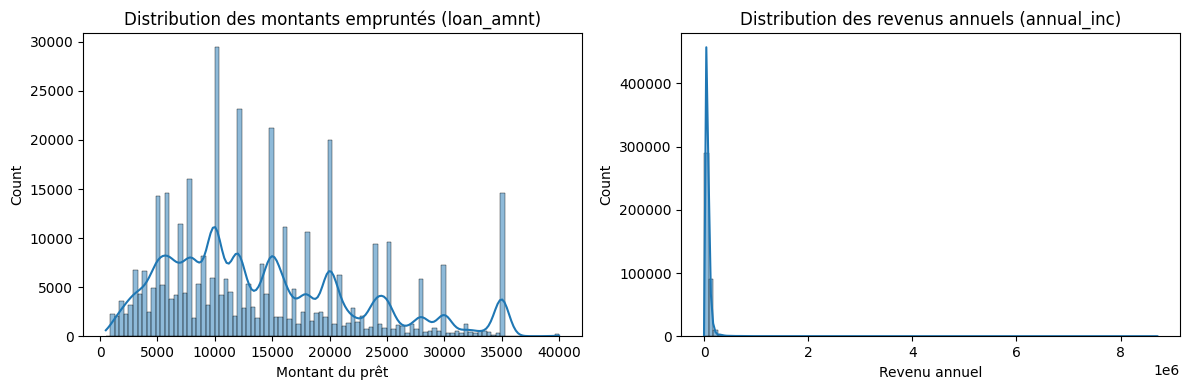

In [24]:
# 📌 Résumé statistique des deux colonnes
print("Statistiques prêt demandé (loan_amnt) :")
print(df['loan_amnt'].describe())

print("\nStatistiques revenu annuel (annual_inc) :")
print(df['annual_inc'].describe())

# 📈 Distribution simple pour visualiser rapidement
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['loan_amnt'], bins=100, kde=True)
plt.title("Distribution des montants empruntés (loan_amnt)")
plt.xlabel("Montant du prêt")

plt.subplot(1, 2, 2)
sns.histplot(df['annual_inc'], bins=100, kde=True)
plt.title("Distribution des revenus annuels (annual_inc)")
plt.xlabel("Revenu annuel")

plt.tight_layout()
plt.show()

In [25]:
# Définir un seuil pour identifier les grands écarts (vous pouvez ajuster ce seuil)
threshold_large_percentage = 5  # Exemple : écart de plus de 5% en valeur absolue

# Isoler les lignes où l'écart en pourcentage dépasse le seuil de grand écart
grand_ecart_rows = df[abs(df['percentage_difference']) > threshold_large_percentage]

# Afficher les lignes avec un grand écart en pourcentage
print(f"Lignes avec un écart en pourcentage supérieur à {threshold_large_percentage}% en valeur absolue :")
print(grand_ecart_rows[['installment', 'monthly_payment_calculated', 'percentage_difference']])

# Vous pouvez également afficher le nombre de ces lignes
print("\nNombre de lignes avec un grand écart :", len(grand_ecart_rows))

Lignes avec un écart en pourcentage supérieur à 5% en valeur absolue :
        installment  monthly_payment_calculated  percentage_difference
9             928.4                 9283.998464             899.999835
12            239.1                 2390.918392             899.965869
13            783.7                 7836.945052             899.992989
15            567.3                 5672.986514             899.997623
18          10638.7                 9559.911488             -10.140229
...             ...                         ...                    ...
396007       5258.8                 4268.938703             -18.822950
396008        426.1                 4260.974529             899.994022
396010       3175.4                 2816.056034             -11.316494
396012        863.8                 6722.801867             678.282226
396015        127.5                 1274.970041             899.976503

[72492 rows x 3 columns]

Nombre de lignes avec un grand écart : 72492


In [26]:
# 🔹 Revenu mensuel estimé
df['monthly_income_estimated'] = df['annual_inc'] / 12

# 🔹 Dette mensuelle estimée à partir du DTI
df['monthly_debt_from_dti'] = df['dti'] * df['monthly_income_estimated'] / 100  # car DTI est en %

# 🔹 Comparaison avec la mensualité calculée
df['debt_minus_monthly_payment'] = df['monthly_debt_from_dti'] - df['monthly_payment_calculated']

# 🔹 Statistiques d’écart
print("Écart entre dette mensuelle estimée via DTI et mensualité calculée :")
print(df['debt_minus_monthly_payment'].describe())

# 🔹 Proportion de cas où la mensualité dépasse la dette déclarée (anomalie)
anomalies = df[df['monthly_payment_calculated'] > df['monthly_debt_from_dti']]
print(f"Nombre de cas où la mensualité dépasse la dette déclarée via DTI : {len(anomalies)}")
print(f"Soit {len(anomalies) / len(df):.2%} du total")

Écart entre dette mensuelle estimée via DTI et mensualité calculée :
count    3.960300e+05
mean     9.096306e+04
std      1.025612e+05
min     -1.408122e+04
25%      3.917614e+04
50%      7.600741e+04
75%      1.197270e+05
max      6.331838e+06
Name: debt_minus_monthly_payment, dtype: float64
Nombre de cas où la mensualité dépasse la dette déclarée via DTI : 6808
Soit 1.72% du total


In [27]:
# 🔍 On filtre les revenus au-dessus du 99e percentile
income_threshold = df['annual_inc'].quantile(0.99)
df_filtered = df[df['annual_inc'] <= income_threshold]

# Recalcul des variables dérivées
df_filtered['monthly_income_estimated'] = df_filtered['annual_inc'] / 12
df_filtered['monthly_debt_from_dti'] = df_filtered['dti'] * df_filtered['monthly_income_estimated'] / 100
df_filtered['debt_minus_monthly_payment'] = df_filtered['monthly_debt_from_dti'] - df_filtered['monthly_payment_calculated']

# Affichage de la statistique sur l'écart corrigé
print("Écart (filtré) entre dette mensuelle estimée via DTI et mensualité recalculée :")
print(df_filtered['debt_minus_monthly_payment'].describe())

# Proportion de mensualités supérieures à la dette déclarée (filtré)
anomalies_filtered = df_filtered[df_filtered['monthly_payment_calculated'] > df_filtered['monthly_debt_from_dti']]
print(f"\nCas incohérents (filtré) : {len(anomalies_filtered)} / {len(df_filtered)}")
print(f"Soit {len(anomalies_filtered) / len(df_filtered):.2%}")

Écart (filtré) entre dette mensuelle estimée via DTI et mensualité recalculée :
count    392069.000000
mean      85645.502247
std       66281.636813
min      -14081.216358
25%       38859.218508
50%       75451.815068
75%      118344.097653
max      947424.226858
Name: debt_minus_monthly_payment, dtype: float64

Cas incohérents (filtré) : 6773 / 392069
Soit 1.73%


C:\Users\Pierre\AppData\Local\Temp\ipykernel_11436\3358438991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['monthly_income_estimated'] = df_filtered['annual_inc'] / 12
C:\Users\Pierre\AppData\Local\Temp\ipykernel_11436\3358438991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['monthly_debt_from_dti'] = df_filtered['dti'] * df_filtered['monthly_income_estimated'] / 100
C:\Users\Pierre\AppData\Local\Temp\ipykernel_11436\3358438991.py:8: SettingWithCopyWarning: 
A value is t

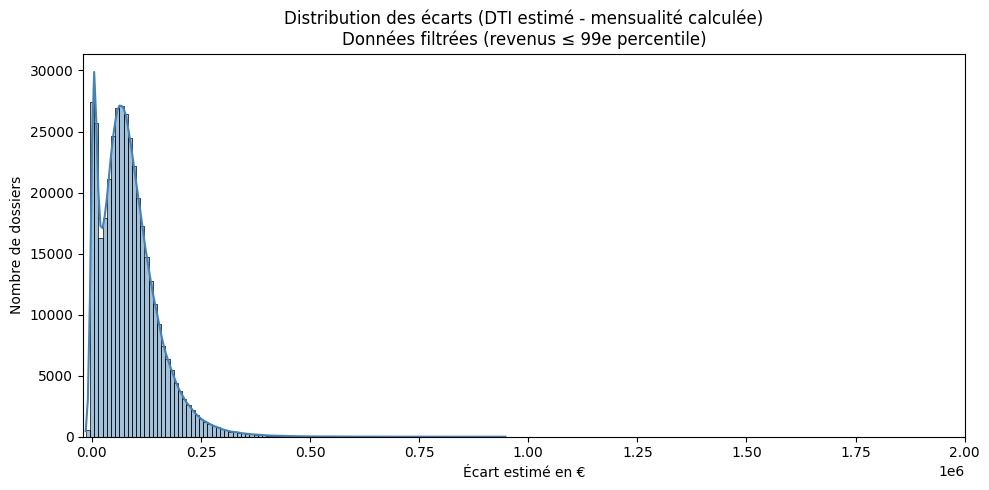

In [28]:
# 🎯 Objectif : Visualiser la répartition des écarts, tout en excluant les cas extrêmes
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['debt_minus_monthly_payment'], bins=100, kde=True, color='steelblue')

# Limiter l'axe X pour éviter les outliers
plt.xlim(-20000, 2000000)
plt.title("Distribution des écarts (DTI estimé - mensualité calculée)\nDonnées filtrées (revenus ≤ 99e percentile)")
plt.xlabel("Écart estimé en €")
plt.ylabel("Nombre de dossiers")
plt.tight_layout()
plt.show()